# Import

# Configure

In [527]:

warnings.filterwarnings('ignore')

# --- 0. Configuration & Helper Functions ---
TARGET_VARIABLE = 'interest_income_to_assets'
FEATURE_VARIABLES = ['gdp_qoq', 'deposit_ratio', 'loan_to_asset_ratio', 'log_total_assets', 'cpi_qoq', 'unemployment', 
                     'household_delinq', 'tbill_3m', 'tbill_10y', 'spread_10y_3m', 'bank_id']
FORECAST_HORIZONS = list(range(1, 2))  # 1 to 8 quarters ahead
# Test split ratio
TRAIN_TEST_SPLIT_DIMENSION = 'date'
TEST_SPLIT_RATIO = 0.2
N_SPLITS_CV = 3

# Data cut offs
DATA_BEGIN = None # '2000-01-01'  # Start date for the data
DATA_END = None # '2009-01-01'  # End date for the data

# Cleaning parameters
RESTRICT_TO_NUMBER_OF_BANKS = 50  # If a number, restrict to this many banks
RESTRICT_TO_BANK_SIZE = 10e6  # If a number, restrict to banks with total assets >= this value
RESTRICT_TO_MINIMAL_DEPOSIT_RATIO = 0.1 #0.5  # If a number, restrict to banks with deposit ratio >= this value
RESTRICT_TO_MAX_CHANGE_IN_DEPOSIT_RATIO = 0.1  # If a number, restrict to banks with change in deposit ratio <= this value

# Regression parameters
INCLUDE_TIME_FEATURES = False  # Include time features in the regression
INCLUDE_UNIT_FEATURES = True  # Include unit features in the regression, i.e. bank identifiers


# Load

In [528]:
data_precleaning = pd.read_parquet('data.parquet')

# Drop observations after a certain date
# df = df[df.index <= '2011-12-31']

# Additional cleaning
nr_cells = data_precleaning.shape[0] * data_precleaning.shape[1]
nr_na = data_precleaning.isna().sum().sum()
print(f"Number of NaNs in data: {nr_na} ({nr_na / nr_cells * 100:.2f}%)")
print(f"Removing NAs from the dataset...")

# Initialize 'data' from 'data_precleaning' to work with
data = data_precleaning.copy()

# Add time and unit features if specified
if INCLUDE_TIME_FEATURES:
    data['quarter'] = data.index.get_level_values('date').quarter
    data['year'] = data.index.get_level_values('date').year
if INCLUDE_UNIT_FEATURES:
    # 'id' consists of bank identifiers, which we will convert to categorical codes
    data['bank_id'] = data.index.get_level_values('id').astype('category').codes  # Convert bank IDs to categorical codes

# Now that 'data' potentially has 'quarter' and 'bank_id' columns,
# perform dropna on this modified 'data' DataFrame.
data = data.dropna(subset=FEATURE_VARIABLES + [TARGET_VARIABLE]).copy()



Number of NaNs in data: 13117236 (14.97%)
Removing NAs from the dataset...


In [529]:
# Delete outliers in the target variable
from matplotlib.pylab import f


def remove_outliers(df, target_col, threshold=3):
    """Remove outliers based on z-score."""
    z_scores = np.abs((df[target_col] - df[target_col].mean()) / df[target_col].std())
    return df[z_scores < threshold]
print(f"Removing outliers from the target variable '{TARGET_VARIABLE}'...")
nr_cells_before = data.shape[0]
data = remove_outliers(data, TARGET_VARIABLE)
print(f"Number of observations before removing outliers: {nr_cells_before}")
nr_cells_after = data.shape[0]
print(f"Number of observations after removing outliers: {nr_cells_after}")


# Remove banks with too few observations
min_observations = 10  # Minimum number of observations per bank
def remove_banks_with_few_observations(df, min_observations=min_observations):
    """Remove banks with fewer than a specified number of observations."""
    bank_counts = df.index.get_level_values('id').value_counts()
    banks_to_remove = bank_counts[bank_counts < min_observations].index
    return df[~df.index.get_level_values('id').isin(banks_to_remove)]
print(f"Removing banks with fewer than {min_observations} observations...")
nr_cells_before = data.shape[0]
print(f"Number of observations before removing banks: {nr_cells_before}")
data = remove_banks_with_few_observations(data, min_observations=10)
nr_cells_after = data.shape[0]
print(f"Number of observations after removing banks: {nr_cells_after}")


Removing outliers from the target variable 'interest_income_to_assets'...
Number of observations before removing outliers: 628056
Number of observations after removing outliers: 623015
Removing banks with fewer than 10 observations...
Number of observations before removing banks: 623015
Number of observations after removing banks: 618866


In [530]:
# Pre-process catgorical features
data['bank_id'] = 'bank_id_' + data['bank_id'].astype(str)

# Restrict sample

In [531]:
# Write a function that restricts the bank sample. There are two options: random sampling or selecting banks with average total assets in the last 5 years above a certain treshold. The threshold is 100bln by default. 
# Note: "last 5 years" is not implemented; current logic uses overall average total assets.


# Default arguments use the global variables from cell 3 (RESTRICT_TO_NUMBER_OF_BANKS, etc.)
def restrict_sample(df, 
                    begin_date = DATA_BEGIN,
                    end_date = DATA_END,
                    number_of_banks = RESTRICT_TO_NUMBER_OF_BANKS, 
                    bank_size       = RESTRICT_TO_BANK_SIZE, # Interpreted as asset threshold
                    deposit_ratio_threshold = RESTRICT_TO_MINIMAL_DEPOSIT_RATIO, 
                    max_change_deposit_ratio = RESTRICT_TO_MAX_CHANGE_IN_DEPOSIT_RATIO): # Interpreted as deposit ratio threshold
    
    df_processed = df.copy()

    # --- Sequential Filtering ---

    if begin_date is not None:
        df_processed = df_processed[df_processed.index.get_level_values('date') >= begin_date]
        print(f"Filtered to {df_processed.index.get_level_values('date').min()} and later dates.")

    if end_date is not None:
        df_processed = df_processed[df_processed.index.get_level_values('date') <= end_date]
        print(f"Filtered to {df_processed.index.get_level_values('date').max()} and earlier dates.")
    if df_processed.empty:
        print("Warning: DataFrame is empty after date filtering. Returning empty DataFrame.")
        return df_processed.iloc[0:0]

    if max_change_deposit_ratio is not None:
        df_processed['abs_change'] = df_processed.groupby(level='id')['deposit_ratio'].diff().abs().fillna(0)
        df_processed = df_processed[df_processed['abs_change'] <= max_change_deposit_ratio]
        
        if df_processed.empty and not df.empty and number_of_banks is None: # Check if this filter (when it's the first active one) emptied DataFrame
             print("Warning: DataFrame became empty after max change in deposit ratio filter.")
             return df_processed

    # 1. Filter by bank_size (asset threshold)
    if bank_size is not None: # bank_size is the threshold for average total assets
        if df_processed.empty:
            print("DataFrame is already empty before bank_size filter. Skipping.")
        elif 'total_assets' not in df_processed.columns:
            print("Warning: 'total_assets' column not found. Cannot filter by bank_size.")
        else:
            avg_assets = df_processed.groupby(level='id')['total_assets'].mean()
            ids_meeting_size_criteria = avg_assets[avg_assets >= bank_size].index
            
            if not ids_meeting_size_criteria.empty:
                df_processed = df_processed[df_processed.index.get_level_values('id').isin(ids_meeting_size_criteria)]
                print(f"Filtered to {df_processed.index.get_level_values('id').nunique()} banks with average total assets >= {bank_size}.")
            else:
                print(f"Warning: No banks in current df_processed meet average total assets >= {bank_size}. DataFrame will be empty.")
                return df_processed.iloc[0:0] # Return empty DataFrame with original columns
        
        if df_processed.empty and not df.empty and number_of_banks is None: # Check if this filter (when it's the first active one) emptied DataFrame
             print("Warning: DataFrame became empty after bank_size filter.")
             return df_processed

    # 2. Filter by deposit_ratio_threshold (minimum deposit ratio for a bank)
    if deposit_ratio_threshold is not None:
        if df_processed.empty:
            print("DataFrame is already empty before deposit_ratio_threshold filter. Skipping.")
        elif 'deposit_ratio' not in df_processed.columns:
            print("Warning: 'deposit_ratio' column not found. Cannot filter by deposit_ratio_threshold.")
        else:
            min_ratios_per_bank = df_processed.groupby(level='id')['deposit_ratio'].min()
            ids_meeting_deposit_criteria = min_ratios_per_bank[min_ratios_per_bank >= deposit_ratio_threshold].index

            if not ids_meeting_deposit_criteria.empty:
                df_processed = df_processed[df_processed.index.get_level_values('id').isin(ids_meeting_deposit_criteria)]
                print(f"Filtered to {df_processed.index.get_level_values('id').nunique()} banks with minimum deposit ratio >= {deposit_ratio_threshold}.")
            else:
                print(f"Warning: No banks in current df_processed meet minimum deposit ratio >= {deposit_ratio_threshold}. DataFrame will be empty.")
                return df_processed.iloc[0:0]
        
        if df_processed.empty and not df.empty and number_of_banks is None and bank_size is None: # Check if this filter (when it's the first active one) emptied DataFrame
             print("Warning: DataFrame became empty after deposit_ratio_threshold filter.")
             return df_processed
        
        # 3. Filter by number_of_banks (random sampling)
    if number_of_banks is not None:
        if not isinstance(number_of_banks, int) or number_of_banks <= 0:
            print(f"Warning: 'number_of_banks' must be a positive integer. Value: {number_of_banks}. Skipping this filter.")
        else:
            current_bank_ids_in_df = df_processed.index.get_level_values('id').unique()
            if len(current_bank_ids_in_df) == 0:
                print(f"No banks available for sampling from df_processed (input to this filter step is empty or has no banks).")
            elif len(current_bank_ids_in_df) > number_of_banks:
                sampled_ids = pd.Series(current_bank_ids_in_df).sample(n=number_of_banks, random_state=42, replace=False).values
                df_processed = df_processed[df_processed.index.get_level_values('id').isin(sampled_ids)]
                print(f"Randomly selected {df_processed.index.get_level_values('id').nunique()} banks.")
            else:
                print(f"Requested {number_of_banks} banks for sampling, but only {len(current_bank_ids_in_df)} available in df_processed. Using all available from current set.")
        
        if df_processed.empty and not df.empty: # Check if this filter step emptied a non-empty DataFrame
            print("Warning: DataFrame became empty after number_of_banks filter.")
            return df_processed # Early exit if empty
                
    return df_processed

# Restrict the bank sample if configured
print(f"Restrict bank sample in 'data'.")
data_before_restriction_shape = data.shape
nr_banks_before_restriction = data.index.get_level_values('id').nunique()

data = restrict_sample(data, 
                            bank_size=RESTRICT_TO_BANK_SIZE, 
                            number_of_banks=RESTRICT_TO_NUMBER_OF_BANKS, 
                            deposit_ratio_threshold=RESTRICT_TO_MINIMAL_DEPOSIT_RATIO 
                            )

print(f"Number of banks before restriction: {nr_banks_before_restriction}, after restriction: {data.index.get_level_values('id').nunique() if not data.empty else 0}")
print(f"Shape of 'data' before restriction: {data_before_restriction_shape}, after restriction: {data.shape}")
if data.empty and data_before_restriction_shape[0] > 0 :
    print("Warning: 'data' DataFrame is empty after bank sample restriction. Check threshold or sampling logic.")
    


Restrict bank sample in 'data'.
Filtered to 170 banks with average total assets >= 10000000.0.
Filtered to 157 banks with minimum deposit ratio >= 0.1.
Randomly selected 50 banks.
Number of banks before restriction: 9930, after restriction: 50
Shape of 'data' before restriction: (618866, 137), after restriction: (3090, 138)


# Plot the data

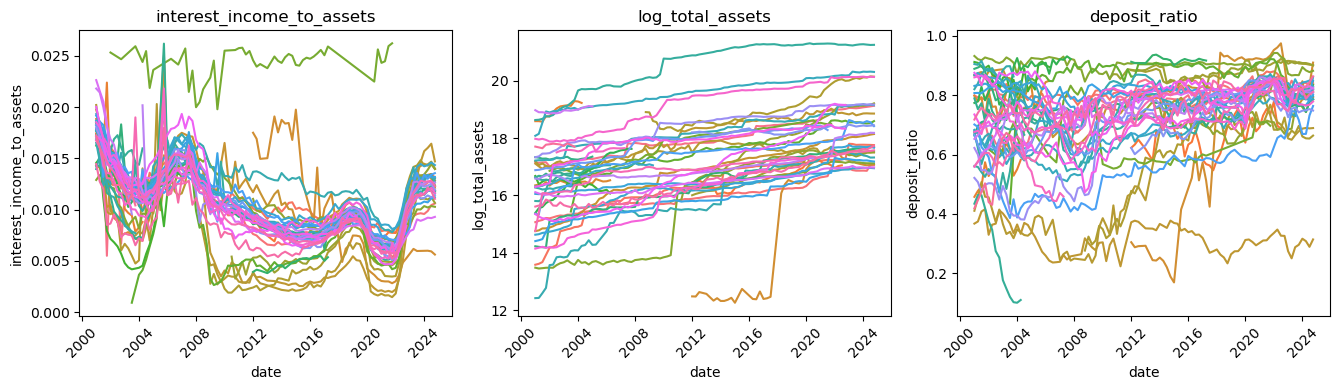

In [533]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

def plot_features_timeseries_flat(
    df: pd.DataFrame, 
    date_column: str = None, 
    id_column: str = None, 
    feature_columns: List[str] = None
):
    """
    Plots each specified feature of a DataFrame as a time series in a separate subplot,
    arranged in a 3-column grid. Each unique ID (from id_column) is plotted
    with a distinct color. The DataFrame is expected to be "flat", meaning
    date and ID are regular columns.

    Args:
        df (pd.DataFrame): DataFrame with date, id, and feature columns.
        date_column (str, optional): Name of the column containing date/time data.
                                     Defaults to 'Date'.
                                     This column should be sortable (e.g., datetime objects).
        id_column (str, optional): Name of the column containing ID data for hue.
                                   Defaults to 'id'.
        feature_columns (List[str], optional): List of column names for features to plot.
                                               Defaults to all columns not used as date_column or id_column.
    """
    # --- Input Validation ---
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")

    # --- Determine column names if not provided ---
    if date_column is None:
        date_column = 'date'
    if id_column is None:
        id_column = 'id'
    if feature_columns is None:
        feature_columns = [col for col in df.columns if col not in [date_column, id_column]]

    required_cols = [date_column, id_column] + feature_columns
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns in DataFrame: {', '.join(missing_cols)}")


    if not feature_columns:
        print("No feature columns provided to plot.")
        return
    
    # Ensure date column is suitable for plotting (e.g., convert to datetime if it's string)
    # For simplicity, we'll assume it's already in a plottable format (datetime or numeric)
    # but in a real scenario, you might add:
    # if not pd.api.types.is_datetime64_any_dtype(df[date_column]) and \
    #    not pd.api.types.is_numeric_dtype(df[date_column]):
    #     try:
    #         df[date_column] = pd.to_datetime(df[date_column])
    #     except Exception as e:
    #         print(f"Warning: Could not convert date_column '{date_column}' to datetime: {e}")

    num_features = len(feature_columns)

    # --- Setup for plotting ---
    num_cols_grid = 3
    num_rows_grid = (num_features + num_cols_grid - 1) // num_cols_grid

    fig, axes = plt.subplots(
        num_rows_grid, num_cols_grid, 
        figsize=(5 * num_cols_grid, 4 * num_rows_grid), 
        sharex=True # Share x-axis for easier comparison
    )

    # Flatten axes array for easy iteration, handling single row/col cases
    axes_flat: np.ndarray[plt.Axes]
    if num_rows_grid == 1 and num_cols_grid == 1:
        axes_flat = np.array([axes])
    elif num_rows_grid == 1 or num_cols_grid == 1:
        axes_flat = axes if isinstance(axes, np.ndarray) else np.array([axes])
    else:
        axes_flat = axes.flatten()

    # --- Create plots ---
    legend_handles_map = {} # Using dict to ensure unique labels for the figure legend

    for i, feature_name in enumerate(feature_columns):
        ax = axes_flat[i]
        
        sns.lineplot(
            data=df,
            x=date_column,
            y=feature_name,
            hue=id_column,
            ax=ax,
            legend=True # Generate legend for this subplot to extract handles
        )
        
        # Collect unique handles and labels for the figure-level legend
        handles, labels = ax.get_legend_handles_labels()
        for handle, label in zip(handles, labels):
            if label not in legend_handles_map: # Add if label is new
                legend_handles_map[label] = handle
        
        if ax.get_legend() is not None:
            ax.get_legend().remove() # Remove individual subplot legend

        ax.set_title(f'{feature_name}')
        ax.set_xlabel(date_column) # Use the provided date_column name
        ax.set_ylabel(feature_name)
        ax.tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(num_features, len(axes_flat)):
        fig.delaxes(axes_flat[j])



    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend
    plt.show()

all_data = pd.concat([X, y], axis=1)

plot_features_timeseries_flat(all_data.reset_index(), feature_columns=[TARGET_VARIABLE] + ['log_total_assets', 'deposit_ratio'])

# Run regressions

In [534]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
import sklearn.dummy
from xgboost import XGBRegressor
from prophet import Prophet # Make sure Prophet is installed
from IPython.display import display # For better display in Jupyter

# --- Configuration (Potentially move to a separate config file or section) ---
# --- !! IMPORTANT !! ---
# Ensure the following variables are defined in your Jupyter Notebook environment
# before running this cell:
#
# all_data: pd.DataFrame
#           Your full dataset. It must either have a MultiIndex with levels 'id' and 'date',
#           or have 'id' and 'date' as columns that can be set as a MultiIndex.
#           The 'date' column/level should be datetime-like.
#
# TARGET_VARIABLE: str
#           The name of the column in 'all_data' to be used as the target variable.
#           e.g., TARGET_VARIABLE = "your_target_column_name"
#
# FEATURE_VARIABLES: list
#           A list of column names in 'all_data' to be used as feature variables.
#           These should ideally be numerical for most models, or will be handled
#           as is by models that can take categorical features (like tree-based ones if not OHE'd).
#           e.g., FEATURE_VARIABLES = ["feature1", "feature2"]
#
# TRAIN_TEST_SPLIT_DIMENSION: str
#           The dimension along which to split the data.
#           Can be "date" (chronological split for time series) or
#           "id" (split by unique identifiers, e.g., for panel data generalization to new IDs).
#           e.g., TRAIN_TEST_SPLIT_DIMENSION = "date"
#
# FORECAST_HORIZONS: list
#           A list of integers representing the number of time steps ahead to forecast.
#           e.g., FORECAST_HORIZONS = [1, 2, 4] # For 1-quarter, 2-quarters, 4-quarters ahead
#
# TEST_SPLIT_RATIO: float
#           The proportion of the dataset to allocate to the final hold-out test set
#           (e.g., 0.2 for 20%).
#           e.g., TEST_SPLIT_RATIO = 0.2
#
# N_SPLITS_CV: int
#           The number of splits for TimeSeriesSplit cross-validation during hyperparameter tuning.
#           e.g., N_SPLITS_CV = 3
# --- End of Required User Definitions ---


# --- Helper Functions ---

def prepare_data_for_horizon(
    df_full: pd.DataFrame,
    target_col_name: str,
    features_list: list,
    horizon: int,
    train_test_split_dimension: str,
    test_ratio: float
) -> tuple:
    """
    Prepares features (X) and target (y) for a given forecast horizon from panel data.
    Handles MultiIndex, creates multi-step target, splits data, and scales features.
    """
    if not isinstance(df_full.index, pd.MultiIndex) or \
       not all(name in df_full.index.names for name in ['id', 'date']):
        if 'id' in df_full.columns and 'date' in df_full.columns:
            print("Input DataFrame does not have ('id', 'date') MultiIndex. Setting it now.")
            df_full = df_full.set_index(['id', 'date'])
        else:
            raise ValueError("df_full must have a MultiIndex with 'id' and 'date' levels, "
                             "or 'id' and 'date' columns to set as MultiIndex.")
    df_full = df_full.sort_index() # Ensure data is sorted by id and then date

    df_h = df_full.copy() # Work on a copy
    shifted_target_col = f'{target_col_name}_target_h{horizon}'
    # Group by 'id' to ensure the shift is done within each unit's timeline
    df_h[shifted_target_col] = df_h.groupby(level='id', group_keys=False)[target_col_name].shift(-horizon)
    df_h.dropna(subset=[shifted_target_col], inplace=True) # Drop NaNs created by shifting

    if df_h.empty:
        print(f"DataFrame is empty for horizon {horizon} after creating target. Skipping.")
        return None, None, None, None, None, None

    # Ensure only requested features_list are taken, plus the target
    if not all(feat in df_h.columns for feat in features_list):
        missing_feats = [feat for feat in features_list if feat not in df_h.columns]
        raise ValueError(f"Features {missing_feats} not found in dataframe after target creation.")

    y = df_h[shifted_target_col]
    X_orig = df_h[features_list].copy() # Use .copy() to avoid potential view issues

    if X_orig.empty or y.empty:
        print(f"X or y is empty for horizon {horizon} before splitting. Skipping.")
        return None, None, None, None, None, None

    X_train_orig_df, X_test_orig_df, y_train, y_test = None, None, None, None

    if train_test_split_dimension == "date":
        unique_dates = X_orig.index.get_level_values('date').unique().sort_values()
        if len(unique_dates) < 2: # Need at least two unique dates to split
            print(f"Not enough unique dates to perform a chronological split for horizon {horizon}. Skipping.")
            return None, None, None, None, None, None

        split_idx = int(len(unique_dates) * (1 - test_ratio))
        if split_idx == 0 or split_idx >= len(unique_dates): # Avoid empty train or test set by date
             print(f"Test ratio results in empty train or test set based on unique dates for horizon {horizon}. Skipping.")
             return None, None, None, None, None, None

        split_date = unique_dates[split_idx -1] # Data UP TO this date for train

        train_mask = X_orig.index.get_level_values('date') <= split_date
        test_mask = X_orig.index.get_level_values('date') > split_date

        X_train_orig_df = X_orig[train_mask]
        X_test_orig_df = X_orig[test_mask]
        y_train = y[train_mask]
        y_test = y[test_mask]

    elif train_test_split_dimension == "id":
        unique_ids_in_X = X_orig.index.get_level_values('id').unique()
        if len(unique_ids_in_X) < 2:
            print(f"Not enough unique IDs in X_orig ({len(unique_ids_in_X)}) for split by ID (horizon {horizon}). Skipping.")
            return None, None, None, None, None, None

        # Calculate number of test IDs, ensure it's at least 1 if ratio > 0 and less than total
        num_test_ids = int(np.ceil(len(unique_ids_in_X) * test_ratio))
        if test_ratio > 0 and num_test_ids == 0: num_test_ids = 1
        if num_test_ids == 0 or num_test_ids >= len(unique_ids_in_X):
            print(f"Test ratio ({test_ratio}) for {len(unique_ids_in_X)} IDs results in invalid test set size ({num_test_ids}). Skipping.")
            return None, None, None, None, None, None

        X_orig_reset = X_orig.reset_index()
        y_reset = y.reset_index()

        gss = GroupShuffleSplit(n_splits=1, test_size=num_test_ids, random_state=42)
        try:
            train_idx, test_idx = next(gss.split(X_orig_reset, y_reset, groups=X_orig_reset['id']))
        except ValueError as e:
            print(f"Error during GroupShuffleSplit for horizon {horizon}: {e}. Skipping.")
            return None, None, None, None, None, None

        X_train_orig_df = X_orig_reset.iloc[train_idx].set_index(['id', 'date']).sort_index()
        X_test_orig_df = X_orig_reset.iloc[test_idx].set_index(['id', 'date']).sort_index()
        y_train = y_reset.iloc[train_idx].set_index(['id', 'date'])[shifted_target_col].sort_index()
        y_test = y_reset.iloc[test_idx].set_index(['id', 'date'])[shifted_target_col].sort_index()
    else:
        raise ValueError("train_test_split_dimension must be 'date' or 'id'")

    if X_train_orig_df.empty or y_train.empty or X_test_orig_df.empty or y_test.empty:
        print(f"Train or test set is empty after split for horizon {horizon}. Check test_ratio and data. Skipping.")
        return None, None, None, None, None, None

    # --- Feature Scaling (only numeric features in features_list) ---
    scaler = StandardScaler()
    # Select only numeric columns from features_list for scaling
    numeric_features_in_list = X_train_orig_df[features_list].select_dtypes(include=np.number).columns
    
    X_train_scaled_df = X_train_orig_df.copy()
    X_test_scaled_df = X_test_orig_df.copy()

    if not numeric_features_in_list.empty:
        X_train_scaled_df[numeric_features_in_list] = scaler.fit_transform(X_train_orig_df[numeric_features_in_list])
        
        # Check if test set has these numeric features before transforming
        numeric_features_in_test = X_test_orig_df[features_list].select_dtypes(include=np.number).columns
        common_numeric_to_scale = numeric_features_in_list.intersection(numeric_features_in_test)
        
        if not common_numeric_to_scale.empty:
            X_test_scaled_df[common_numeric_to_scale] = scaler.transform(X_test_orig_df[common_numeric_to_scale])
        elif not X_test_orig_df.empty : # If test set is not empty but no common numeric features to scale
             print(f"Warning: No common numeric features from training to scale in test data for horizon {horizon}.")
    else:
        print(f"Warning: No numeric features in FEATURE_VARIABLES to scale in training data for horizon {horizon}.")

    # Ensure final dataframes only contain features from features_list
    X_train_scaled_df = X_train_scaled_df[features_list]
    X_test_scaled_df = X_test_scaled_df[features_list]

    return X_train_scaled_df, X_test_scaled_df, y_train, y_test, X_train_orig_df, X_test_orig_df

def preprocess_for_fixed_effects(X_train_orig: pd.DataFrame, X_test_orig: pd.DataFrame,
                                 id_col_name: str, numerical_feature_cols: list):
    """Prepares data for Fixed Effects model: OHE for id, Scaling for numerical features."""
    if X_train_orig.empty:
        print("FE Preprocessing: X_train_orig is empty.")
        return pd.DataFrame(index=X_train_orig.index), pd.DataFrame(index=X_test_orig.index)
    # X_test_orig can be empty if test_ratio leads to it, handle downstream.

    X_train_proc = X_train_orig.reset_index()
    X_test_proc = X_test_orig.reset_index() if not X_test_orig.empty else pd.DataFrame(columns=X_train_proc.columns)


    # Identify numerical features that are actually present
    valid_numerical_features = [col for col in numerical_feature_cols if col in X_train_proc.columns]
    
    transformers = []
    if valid_numerical_features:
        transformers.append(('num', StandardScaler(), valid_numerical_features))
    
    # Check if id_col_name is a column to be encoded
    if id_col_name in X_train_proc.columns:
        transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop=None), [id_col_name]))
    else:
        print(f"Warning: ID column '{id_col_name}' not found in X_train_proc columns for OHE during FE preprocessing.")

    if not transformers:
        print("FE Preprocessing: No transformers defined. Returning empty DataFrames with original index.")
        return pd.DataFrame(index=X_train_orig.index), pd.DataFrame(index=X_test_orig.index)

    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

    try:
        X_train_transformed = preprocessor.fit_transform(X_train_proc)
        # Ensure X_test_proc has columns in the same order as X_train_proc for transform, if not empty
        if not X_test_proc.empty:
             X_test_transformed = preprocessor.transform(X_test_proc[preprocessor.feature_names_in_])
        else: # Handle empty test set after preprocessor fitting
             # Create an empty array with the correct number of columns
             num_transformed_cols = X_train_transformed.shape[1]
             X_test_transformed = np.empty((0, num_transformed_cols))

    except ValueError as e:
        print(f"Error during ColumnTransformer fit/transform for FE: {e}")
        return pd.DataFrame(index=X_train_orig.index), pd.DataFrame(index=X_test_orig.index)

    # Get feature names after transformation
    transformed_feature_names = []
    if hasattr(preprocessor, 'get_feature_names_out'): # Use if available (sklearn >= 1.0)
        transformed_feature_names = list(preprocessor.get_feature_names_out())
    else: # Fallback for older scikit-learn versions
        for name, trans, columns in preprocessor.transformers_:
            if name == 'num':
                transformed_feature_names.extend(columns)
            elif name == 'cat' and hasattr(trans, 'categories_'): # OneHotEncoder specific
                for i, col_categories in enumerate(trans.categories_):
                    original_col_name = columns[i]
                    transformed_feature_names.extend([f"{original_col_name}_{cat_val}" for cat_val in col_categories])
            # Note: This fallback might not be perfect for all transformers or complex scenarios.

    X_train_fe_scaled_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names, index=X_train_orig.index)
    if not X_test_orig.empty:
        X_test_fe_scaled_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names, index=X_test_orig.index)
    else: # Create an empty DataFrame with correct columns and index if X_test_orig was empty
        X_test_fe_scaled_df = pd.DataFrame(columns=transformed_feature_names, index=X_test_orig.index)

    return X_train_fe_scaled_df, X_test_fe_scaled_df

def get_models_and_param_grids():
    """Defines models and their hyperparameter grids for GridSearchCV."""
    models = {
        "DummyRegressor": sklearn.dummy.DummyRegressor(strategy="mean"),
        "LinearRegression": LinearRegression(),
        "Lasso": Lasso(random_state=42, max_iter=15000), # Increased max_iter
        "Ridge": Ridge(random_state=42, max_iter=15000), # Increased max_iter
        "ElasticNet": ElasticNet(random_state=42, max_iter=15000), # Increased max_iter
        "DecisionTree": DecisionTreeRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror', n_jobs=-1,
                                early_stopping_rounds=None, enable_categorical = True), # Added early stopping for XGB
        "FixedEffectsLR": LinearRegression() # Added Fixed Effects Linear Regression
    }
    param_grids = {
        "Lasso": {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 20]}, # Expanded alpha
        "Ridge": {'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100]}, # Expanded alpha
        "ElasticNet": {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}, # Expanded l1_ratio
        "DecisionTree": {'max_depth': [None, 5, 10, 15, 20], 'min_samples_split': [2, 5, 10, 20],
                         'min_samples_leaf': [1, 5, 10]},
        "XGBoost": {
            'n_estimators': [20, 30, 35, 40, 45, 50, 100],
            'learning_rate': [0.01, 0.03, 0.05, 0.06, 0.07, 0.08, 0.1, 0.2],
            'max_depth': [1, 2, 3, 5, 7, 9, 11],
            # 'subsample': [0.7, 0.8, 0.9], # Keep params minimal for speed if dataset is small
            # 'colsample_bytree': [0.7, 0.8, 0.9]
        }
    }
    return models, param_grids

def train_evaluate_model(model_name_key, model_instance, X_train, y_train, X_test, y_test, param_grid=None, cv_splitter=None):
    """Trains a single model, tunes if param_grid is provided, and evaluates it."""
    best_model = model_instance # Start with the original instance

    is_xgb = isinstance(model_instance, XGBRegressor)
    fit_params = {}

    # Prepare eval_set for XGBoost if early stopping is active
    # Ensure X_test and y_test are not empty and have consistent lengths
    if is_xgb and hasattr(model_instance, 'early_stopping_rounds') and model_instance.early_stopping_rounds is not None:
        if not X_test.empty and not y_test.empty and len(X_test) == len(y_test):
            # Create a temporary evaluation set from the end of the training data if X_test is very small or for robustness
            # This is a common practice if the provided X_test for final eval shouldn't be seen during tuning.
            # However, for early stopping during the *final* fit, X_test is fine.
            # For GridSearchCV, a separate validation set from train split is used internally.
            # Here, this eval_set is for the *final* model fit after potential tuning.
            fit_params = {'eval_set': [(X_test, y_test)], 'verbose': False}
        else:
            print(f"    XGBoost: Skipping eval_set for early stopping due to empty or misaligned X_test/y_test for {model_name_key}")


    if param_grid and cv_splitter and not X_train.empty:
        print(f"    Tuning {model_name_key}...")
        # Check for sufficient samples for CV
        min_samples_for_cv = cv_splitter.get_n_splits() * 2 # Rough estimate, actual min depends on TimeSeriesSplit logic
        if len(X_train) < min_samples_for_cv :
             print(f"    Skipping tuning for {model_name_key}: not enough samples ({len(X_train)}) for {cv_splitter.get_n_splits()} CV splits. Fitting directly.")
             # Fit directly
             if is_xgb and fit_params: best_model.fit(X_train, y_train, **fit_params)
             else: best_model.fit(X_train, y_train)

        # Check for constant target variable which can cause issues with some models/solvers in CV
        elif len(np.unique(y_train)) == 1 and model_name_key not in ["DummyRegressor", "DecisionTree", "XGBoost"]: # Some models are fine with constant y
            print(f"    Skipping tuning for {model_name_key}: target variable is constant. Fitting directly.")
            best_model.fit(X_train, y_train)
        else:
            try:
                search = GridSearchCV(model_instance, param_grid, cv=cv_splitter, scoring='neg_mean_squared_error', n_jobs=-1)
                search.fit(X_train, y_train) # Note: XGBoost early stopping in CV needs special handling if not using its own CV.
                best_model = search.best_estimator_
                print(f"    Best params for {model_name_key}: {search.best_params_}")
            except Exception as e:
                print(f"    Error during GridSearchCV for {model_name_key}: {e}. Fitting with default params.")
                if is_xgb and fit_params: best_model.fit(X_train, y_train, **fit_params)
                else: best_model.fit(X_train, y_train)
    elif not X_train.empty: # Fit directly if no tuning or if X_train is not empty
        print(f"    Fitting {model_name_key} with default parameters (no tuning).")
        if is_xgb and fit_params: best_model.fit(X_train, y_train, **fit_params)
        else: best_model.fit(X_train, y_train)
    else: # X_train is empty
        print(f"    Skipping fitting for {model_name_key} as X_train is empty.")
        # Return NaNs but keep a model instance if needed (though it's unfitted)
        return {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': model_instance}


    if X_test.empty or y_test.empty:
        print(f"    Skipping prediction for {model_name_key} as X_test or y_test is empty.")
        return {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': best_model}

    try:
        predictions = best_model.predict(X_test)
    except Exception as e:
        print(f"    Error during prediction for {model_name_key} on X_test: {e}")
        return {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': best_model}


    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    
    # MAPE calculation with check for zeros in y_test
    y_test_no_zeros = y_test.replace(0, 0.00001).dropna() # Replace 0 with a small number to avoid division by zero
    if not y_test_no_zeros.empty:
        predictions_no_zeros = pd.Series(predictions, index=y_test.index).loc[y_test_no_zeros.index]
        mape = np.mean(np.abs((y_test_no_zeros - predictions_no_zeros) / y_test_no_zeros)) * 100
    else: # Handle case where y_test_no_zeros might be empty (e.g. all y_test were 0 or NaN)
        mape = np.nan
        
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape, 'model_object': best_model}

def train_evaluate_prophet(X_train_orig, y_train, X_test_orig, y_test, feature_variables_list):
    """Trains and evaluates a Prophet model, using 'date' for 'ds'."""
    print("    Training Prophet model...")
    if X_train_orig.empty or y_train.empty:
        print("    Prophet: Skipping due to empty training input data (X_train_orig or y_train).")
        return None # Or return dict with NaNs
    if X_test_orig.empty or y_test.empty: # If test data is empty, can't evaluate
        print("    Prophet: Skipping evaluation due to empty test input data (X_test_orig or y_test).")
        # Fit a model but return NaN metrics
        df_train_prophet_fit_only = X_train_orig.reset_index()
        df_train_prophet_fit_only['ds'] = pd.to_datetime(df_train_prophet_fit_only['date'])
        df_train_prophet_fit_only['y'] = y_train.values
        m_prophet_fit_only = Prophet()
        valid_regressors_fit_only = [reg for reg in feature_variables_list if reg in df_train_prophet_fit_only.columns]
        for reg in valid_regressors_fit_only: m_prophet_fit_only.add_regressor(reg)
        try:
            m_prophet_fit_only.fit(df_train_prophet_fit_only[['ds', 'y'] + valid_regressors_fit_only])
        except Exception as e_fit:
            print(f"    Error during Prophet fitting (no test eval): {e_fit}")
            m_prophet_fit_only = None # Model fitting failed
        return {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': m_prophet_fit_only}


    # Prepare training data for Prophet
    df_train_prophet = X_train_orig.reset_index() # Get 'id' and 'date' as columns
    df_train_prophet['ds'] = pd.to_datetime(df_train_prophet['date']) # Ensure 'date' is datetime
    df_train_prophet['y'] = y_train.values # y_train is a Series, align its values

    # Prepare future dataframe for Prophet
    df_future_prophet = X_test_orig.reset_index()
    df_future_prophet['ds'] = pd.to_datetime(df_future_prophet['date'])

    # Ensure regressor columns exist
    valid_regressors = [reg for reg in feature_variables_list if reg in df_train_prophet.columns and reg in df_future_prophet.columns]
    if len(valid_regressors) != len(feature_variables_list):
        missing = set(feature_variables_list) - set(valid_regressors)
        print(f"    Prophet: Regressors missing from data: {missing}. Using available: {valid_regressors}")
    
    m_prophet = Prophet() # Add seasonality/changepoint args if needed
    for regressor in valid_regressors:
        m_prophet.add_regressor(regressor)

    try:
        m_prophet.fit(df_train_prophet[['ds', 'y'] + valid_regressors])
        
        # Predict on future dataframe
        # Prophet requires 'ds' and all regressor columns in the future_df
        forecast_prophet = m_prophet.predict(df_future_prophet[['ds'] + valid_regressors])
        
        # Align predictions with y_test.
        # y_test has MultiIndex. Prophet's forecast_prophet does not.
        # This alignment assumes the order of X_test_orig (and thus df_future_prophet)
        # matches the order of y_test when their values are taken.
        # And that Prophet returns predictions for every row in df_future_prophet.
        if len(forecast_prophet['yhat']) != len(y_test):
            print(f"    Prophet WARNING: Forecast length ({len(forecast_prophet['yhat'])}) mismatch with y_test ({len(y_test)}). Slicing predictions.")
            # This could indicate issues if Prophet drops dates or if there's misalignment.
            # A more robust alignment might involve merging on 'ds' and original index if possible.
        predictions_prophet = forecast_prophet['yhat'].values[:len(y_test)]


        mae = mean_absolute_error(y_test, predictions_prophet)
        mse = mean_squared_error(y_test, predictions_prophet)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, predictions_prophet)
        y_test_no_zeros = y_test.replace(0, 0.00001).dropna()
        if not y_test_no_zeros.empty:
            predictions_no_zeros = pd.Series(predictions_prophet, index=y_test.index).loc[y_test_no_zeros.index]
            mape = np.mean(np.abs((y_test_no_zeros - predictions_no_zeros) / y_test_no_zeros)) * 100
        else:
            mape = np.nan
            
        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape, 'model_object': m_prophet}
    except Exception as e:
        print(f"    Error during Prophet training/prediction: {e}")
        return None # Or dict with NaNs and no model object

def train_evaluate_ensemble(trained_models_dict, X_train_scaled, y_train, X_test_scaled, y_test):
    """Trains and evaluates a VotingRegressor ensemble model."""
    print("    Attempting to train Voting Regressor ensemble...")
    if X_train_scaled.empty or y_train.empty:
        print("    VotingEnsemble: Skipping due to empty training data.")
        return None
    if X_test_scaled.empty or y_test.empty:
        print("    VotingEnsemble: Skipping evaluation due to empty test data.")
        return {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': None} # No model if no test data

    estimators = []
    # Example: Use specific, well-performing, diverse models
    # Ensure model objects exist and are not None (e.g. if a base model failed)
    potential_base_models = ["XGBoost", "Ridge", "ElasticNet"] # Prioritize robust models
    for model_name_key in potential_base_models:
        if model_name_key in trained_models_dict and \
           trained_models_dict[model_name_key] and \
           trained_models_dict[model_name_key].get('model_object') is not None:
            # Check if the model object is actually a fitted estimator
            base_model_obj = trained_models_dict[model_name_key]['model_object']
            try: # Check if model is fitted (specific checks might be needed per model type)
                if hasattr(base_model_obj, "coef_") or hasattr(base_model_obj, "feature_importances_") or \
                   (isinstance(base_model_obj, XGBRegressor) and base_model_obj._Booster is not None): # Basic checks
                    estimators.append((model_name_key.lower(), base_model_obj))
                else:
                    print(f"    Base model {model_name_key} for ensemble seems not fitted. Skipping.")
            except AttributeError: # Some models might not have these, or not be sklearn estimators
                 print(f"    Could not verify if base model {model_name_key} is fitted. Skipping for ensemble.")


    if len(estimators) < 2: # VotingRegressor needs at least two estimators
        print("    Not enough suitable (fitted) base models for Voting Regressor. Skipping ensemble.")
        return None

    try:
        voting_reg = VotingRegressor(estimators=estimators, n_jobs=-1)
        # Fit the ensemble - it will re-fit the base estimators if they were not cloned and pre-fitted.
        # The model_objects from results_store are already fitted.
        voting_reg.fit(X_train_scaled, y_train)
        predictions = voting_reg.predict(X_test_scaled)

        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, predictions)
        y_test_no_zeros = y_test.replace(0, 0.00001).dropna()
        if not y_test_no_zeros.empty:
            predictions_no_zeros = pd.Series(predictions, index=y_test.index).loc[y_test_no_zeros.index]
            mape = np.mean(np.abs((y_test_no_zeros - predictions_no_zeros) / y_test_no_zeros)) * 100
        else:
            mape = np.nan
        
        print("    Voting Regressor trained successfully.")
        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape, 'model_object': voting_reg}
    except Exception as e:
        print(f"    Error training Voting Regressor: {e}")
        return None

def aggregate_and_display_results(results_store: dict, plot_result_charts: bool = False, print_final_summary: bool = True):
    """Aggregates results from all horizons and models, prints a summary, and plots RMSE."""
    print("\n\n--- Final Model Performance Summary ---")
    summary_entries = []
    for horizon, models_results in results_store.items():
        for model_name, metrics in models_results.items():
            # Ensure metrics is a dictionary before trying to get keys
            if isinstance(metrics, dict):
                summary_entries.append({
                    'Horizon': horizon,
                    'Model': model_name,
                    'MAE': metrics.get('MAE', np.nan),
                    'RMSE': metrics.get('RMSE', np.nan),
                    'R2': metrics.get('R2', np.nan),
                    'MAPE': metrics.get('MAPE', np.nan)
                })
            else: # Handle cases where metrics might be None or not a dict
                 summary_entries.append({
                    'Horizon': horizon,
                    'Model': model_name, # Still record the model attempt
                    'MAE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan
                })


    if not summary_entries:
        print("No results to display. Check for errors during model training or evaluation.")
        return pd.DataFrame() # Return empty DataFrame if no results

    summary_df = pd.DataFrame(summary_entries)
    summary_df = summary_df.sort_values(by=['Horizon', 'RMSE'])

    if print_final_summary:
        print("Summary DataFrame:")
        display(summary_df) # Use IPython display for better notebook formatting

    if plot_result_charts:
        if summary_df.empty or not FORECAST_HORIZONS or summary_df['RMSE'].isnull().all():
            print("Cannot plot results: summary is empty, RMSE is all NaN, or FORECAST_HORIZONS not defined.")
            return summary_df
            
        plt.figure(figsize=(14, 8))
        unique_models = summary_df['Model'].unique()
        for model_name_plot in unique_models: # Changed variable name to avoid conflict
            model_data = summary_df[summary_df['Model'] == model_name_plot].dropna(subset=['RMSE', 'Horizon']) # Ensure Horizon is also not NaN
            if not model_data.empty:
                 plt.plot(model_data['Horizon'].astype(str), model_data['RMSE'], marker='o', linestyle='-', label=model_name_plot) # Horizon as str for categorical plotting
        
        plt.xlabel("Forecast Horizon (Quarters)")
        plt.ylabel("Root Mean Squared Error (RMSE)")
        plt.title("Model RMSE vs. Forecast Horizon", fontsize=16)
        plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        # plt.xticks(FORECAST_HORIZONS) # If horizons are numeric and you want specific ticks
        plt.tight_layout() # Adjust layout to make room for legend
        plt.show()
    return summary_df

# ==============================================================================
# --- Main Execution Loop (runs directly in Jupyter cell) ---
# ==============================================================================

# Initialize results store
results_store = {}
models_config, param_grids_config = get_models_and_param_grids()

# --- Iterate through each forecast horizon ---
for horizon_val in FORECAST_HORIZONS: # Changed variable name
    print(f"\n--- Processing Horizon: {horizon_val}-quarter(s) ahead ---")
    results_store[horizon_val] = {} # Initialize results for this horizon

    # Prepare data for the current horizon
    prepared_data = prepare_data_for_horizon(
        all_data, TARGET_VARIABLE, FEATURE_VARIABLES, horizon_val, TRAIN_TEST_SPLIT_DIMENSION, TEST_SPLIT_RATIO
    )

    # If data preparation fails for a horizon, fill with NaNs and continue
    if prepared_data is None:
        print(f"  Skipping horizon {horizon_val} due to data preparation failure.")
        # Store NaN results for all models for this horizon to keep structure
        for name_model in models_config.keys():
            results_store[horizon_val][name_model] = {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': None}
        # Also for Prophet and Ensemble if they are treated separately in results
        results_store[horizon_val]['Prophet'] = {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': None}
        results_store[horizon_val]['VotingEnsemble'] = {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': None}
        continue # Move to the next horizon
            
    X_train_scaled_df, X_test_scaled_df, y_train, y_test, X_train_orig, X_test_orig = prepared_data
    
    # TimeSeriesSplit for cross-validation (if enough data)
    current_n_splits_cv = N_SPLITS_CV
    # TimeSeriesSplit needs at least n_splits + 1 samples for the first training set to be non-empty.
    # More practically, len(X_train) should be significantly larger.
    if len(X_train_scaled_df) < current_n_splits_cv + 1 : # Stricter check for TimeSeriesSplit
        print(f"  Warning: Training set size ({len(X_train_scaled_df)}) is too small for {current_n_splits_cv} CV splits. Reducing or skipping CV.")
        if len(X_train_scaled_df) >= 3 and current_n_splits_cv > 1: # Min for 2 splits might be 3 samples.
            current_n_splits_cv = max(1, int(len(X_train_scaled_df) / 2) -1) # Heuristic reduction
            if current_n_splits_cv < 2: current_n_splits_cv = 0 # If too small, no CV
            print(f"  Reduced CV splits to {current_n_splits_cv}.")
        else:
            print(f"  Skipping CV tuning for horizon {horizon_val} due to insufficient training data.")
            current_n_splits_cv = 0 # No CV
    
    tscv_splitter = TimeSeriesSplit(n_splits=current_n_splits_cv) if current_n_splits_cv >= 2 else None # tscv needs at least 2 splits


    # --- Train and Evaluate Standard Models & Fixed Effects Model ---
    for model_name_loop, model_instance_loop in models_config.items(): # Changed variable names
        print(f"  Training {model_name_loop} for horizon {horizon_val}...")
        model_results = None # Initialize
        
        # Check if data is available before attempting to train
        if X_train_scaled_df.empty or y_train.empty:
            # Test data can be empty if test_ratio is very small or data is limited.
            # Prediction/evaluation will handle empty X_test/y_test.
            print(f"    Skipping {model_name_loop} due to empty scaled training data for horizon {horizon_val}.")
            results_store[horizon_val][model_name_loop] = {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': None}
            continue

        if model_name_loop == "FixedEffectsLR":
            if X_train_orig.empty : # FE model needs original data
                print(f"    Skipping {model_name_loop} as original training data (X_train_orig) is empty.")
                results_store[horizon_val][model_name_loop] = {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': None}
                continue
            # 'id' column is expected to be in the index of X_train_orig for reset_index() to work in preprocess_for_fixed_effects
            if 'id' not in X_train_orig.index.names:
                print(f"    Skipping {model_name_loop} as 'id' is not in the index of X_train_orig. Required for fixed effects.")
                results_store[horizon_val][model_name_loop] = {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': None}
                continue

            X_train_fe_df, X_test_fe_df = preprocess_for_fixed_effects(
                X_train_orig, X_test_orig, 'id', FEATURE_VARIABLES # Pass original numerical feature list
            )
            if X_train_fe_df.empty : # Check if FE preproc resulted in empty train data
                print(f"    Skipping {model_name_loop} due to empty data after FE preprocessing for horizon {horizon_val}.")
                results_store[horizon_val][model_name_loop] = {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': None}
                continue
            
            model_results = train_evaluate_model(
                model_name_loop, model_instance_loop, X_train_fe_df, y_train, X_test_fe_df, y_test,
                param_grid=None, cv_splitter=None # No CV/tuning for basic FE LR by default for speed
            )
        else: # For other standard models
            model_results = train_evaluate_model(
                model_name_loop, model_instance_loop, X_train_scaled_df, y_train, X_test_scaled_df, y_test,
                param_grid=param_grids_config.get(model_name_loop), # Get specific param grid
                cv_splitter=tscv_splitter if param_grids_config.get(model_name_loop) and tscv_splitter else None
            )
        
        # Store results, ensuring an entry even if model_results is None
        if model_results:
            results_store[horizon_val][model_name_loop] = model_results
        else:
            results_store[horizon_val][model_name_loop] = {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': None}

    # --- Train and Evaluate Prophet Model ---
    if X_train_orig.empty or y_train.empty : # Check before calling prophet if train data is available
         print(f"  Skipping Prophet for horizon {horizon_val} due to empty original training data.")
         results_store[horizon_val]['Prophet'] = {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': None}
    else:
        prophet_results = train_evaluate_prophet(X_train_orig, y_train, X_test_orig, y_test, FEATURE_VARIABLES)
        if prophet_results:
            results_store[horizon_val]['Prophet'] = prophet_results
        else: # If Prophet fails or returns None
            results_store[horizon_val]['Prophet'] = {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': None}

    # --- (Optional) Train and Evaluate Ensemble Model ---
    # Check if base models were trained and data is available
    if results_store[horizon_val] and not (X_train_scaled_df.empty or y_train.empty):
        ensemble_results = train_evaluate_ensemble(results_store[horizon_val], X_train_scaled_df, y_train, X_test_scaled_df, y_test)
        if ensemble_results:
            results_store[horizon_val]['VotingEnsemble'] = ensemble_results
        else: # If ensemble fails or returns None
            results_store[horizon_val]['VotingEnsemble'] = {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': None}
    else: # If no base models or no training data for ensemble
        results_store[horizon_val]['VotingEnsemble'] = {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan, 'model_object': None}


# --- Aggregate and Display All Results ---
final_summary_df = aggregate_and_display_results(results_store, plot_result_charts=True, print_final_summary=True)

print("\n--- Notes ---")
print("1. Ensure 'TARGET_VARIABLE', 'FEATURE_VARIABLES', 'all_data', and other configurations are correctly defined.")
print("2. The script now includes a 'FixedEffectsLR' model using one-hot encoding for 'id'.")
print("3. Prophet data preparation has been updated to correctly use the 'date' for 'ds'.")
print("4. For 'FixedEffectsLR', if 'train_test_split_dimension' is 'id', fixed effects for new IDs in the test set will generally be all zeros (due to handle_unknown='ignore' in OHE), so the model will rely on other features and an average intercept for these new IDs.")
print("5. MAPE calculation replaces exact zeros in y_test with a very small number to avoid division by zero errors.")
print("6. XGBoost includes early stopping. For GridSearchCV with XGBoost, early stopping is more complex to manage per fold; the current setup applies it to the final fit of the best model and direct fits.")


--- Processing Horizon: 1-quarter(s) ahead ---
  Training DummyRegressor for horizon 1...
    Fitting DummyRegressor with default parameters (no tuning).
  Training LinearRegression for horizon 1...
    Fitting LinearRegression with default parameters (no tuning).


ValueError: could not convert string to float: 'bank_id_495'

# Tests

In [ ]:
# Test the training and evaluation data
# Function that extracts the dates and number of banks in the training and test sets
def extract_dates_and_banks(X_train, X_test):
    """Extracts unique dates and number of banks in training and test sets."""
    train_dates = X_train.index.get_level_values('date').unique()
    test_dates = X_test.index.get_level_values('date').unique()
    
    train_banks = X_train.index.get_level_values('id').nunique()
    test_banks = X_test.index.get_level_values('id').nunique()
    
    return train_dates, test_dates, train_banks, test_banks

train_dates, test_dates, train_banks, test_banks = extract_dates_and_banks(X_train_scaled_df, X_test_scaled_df)
print(f"Training set dates: {len(train_dates)}")
print(f"Test set dates: {len(test_dates)}")
print(f"Number of banks in training set: {train_banks}")
print(f"Number of banks in test set: {test_banks}")

Training set dates: 74
Test set dates: 19
Number of banks in training set: 50
Number of banks in test set: 35


## Plot for each model errors vs. predicted values

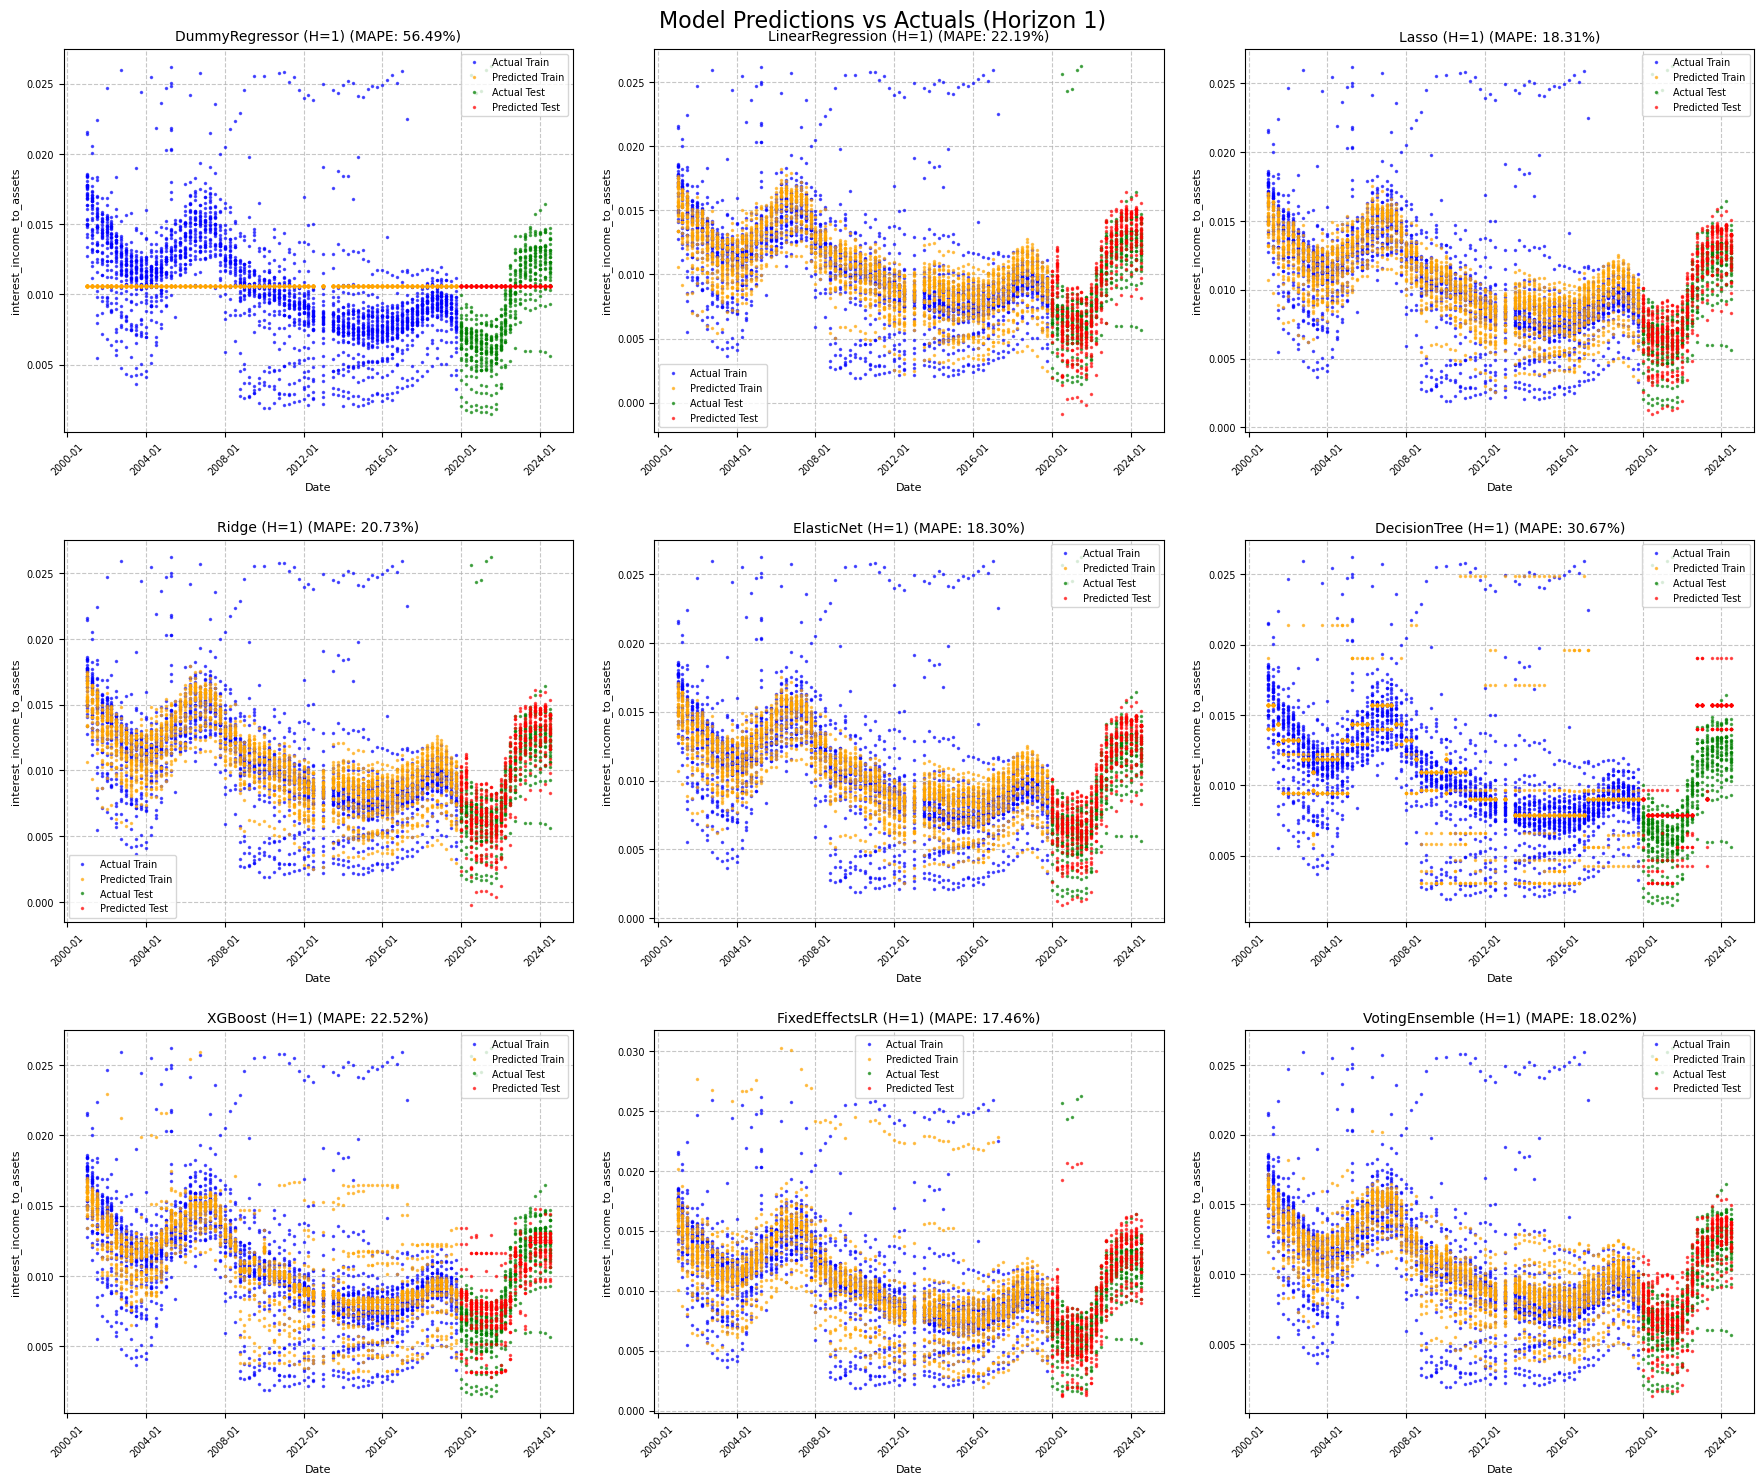

In [ ]:
import math
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported

# --- Plotting Script (Cleaner Version) ---
# ASSUMPTIONS:
# 1. `results_store` is populated from your main script.
# 2. `TARGET_VARIABLE` and `FEATURE_VARIABLES` are defined.
# 3. `X_train_orig`, `X_test_orig`, `y_train`, `y_test`, `X_train_scaled_df`, `X_test_scaled_df`
#    are correctly set to the data corresponding to HORIZON 1 from your main script.
# 4. The `preprocess_for_fixed_effects` function is defined in a previous cell or imported.

results_h1 = results_store.get(1, {}) # Get results for horizon 1

models_to_plot = []
for model_name, metrics in results_h1.items():
    if 'model_object' in metrics and metrics['model_object'] is not None and hasattr(metrics['model_object'], 'predict'):
        # Exclude Prophet for now as it needs special handling for prediction in plots
        if model_name != "Prophet":
            models_to_plot.append((model_name, metrics))

if not models_to_plot:
    print("No suitable models found for horizon 1 to plot.")
else:
    # Sort models by RMSE for plotting (optional, but can be nice)
    # models_to_plot.sort(key=lambda item: item[1].get('RMSE', float('inf')))
    # For now, keeping original order from dictionary for simplicity.

    models_to_plot_count = len(models_to_plot)
    num_cols = 3
    num_rows = math.ceil(models_to_plot_count / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows), squeeze=False)
    axes = axes.flatten()
    plot_index = 0

    for model_name, metrics in models_to_plot:
        ax = axes[plot_index]
        model = metrics['model_object']
        mape = metrics.get('MAPE', float('nan'))

        X_train_for_predict = None
        X_test_for_predict = None

        if model_name == "FixedEffectsLR":
            # Assumes X_train_orig, X_test_orig, FEATURE_VARIABLES are correctly set for Horizon 1
            X_train_for_predict, X_test_for_predict = preprocess_for_fixed_effects(
                X_train_orig, X_test_orig, 'id', FEATURE_VARIABLES
            )
        else: # For other standard models and VotingEnsemble
            # Assumes X_train_scaled_df, X_test_scaled_df are correctly set for Horizon 1
            X_train_for_predict = X_train_scaled_df
            X_test_for_predict = X_test_scaled_df
        
        predictions_train = pd.Series(dtype='float64') # Default to empty
        predictions_test = pd.Series(dtype='float64')  # Default to empty

        if X_train_for_predict is not None and not X_train_for_predict.empty:
            predictions_train = model.predict(X_train_for_predict)
        
        if X_test_for_predict is not None and not X_test_for_predict.empty:
            predictions_test = model.predict(X_test_for_predict)

        # Plotting (assumes y_train, y_test are correctly set for Horizon 1)
        if not y_train.empty:
            x_train_dates = y_train.index.get_level_values('date')
            ax.plot(x_train_dates, y_train.values, label='Actual Train', color='blue', marker='.', linestyle='', markersize=3, alpha=0.6)
            if len(predictions_train) == len(x_train_dates):
                ax.plot(x_train_dates, predictions_train, label='Predicted Train', color='orange', marker='.', linestyle='', markersize=3, alpha=0.6)

        if not y_test.empty:
            x_test_dates = y_test.index.get_level_values('date')
            ax.plot(x_test_dates, y_test.values, label='Actual Test', color='green', marker='.', linestyle='', markersize=3, alpha=0.6)
            if len(predictions_test) == len(x_test_dates):
                ax.plot(x_test_dates, predictions_test, label='Predicted Test', color='red', marker='.', linestyle='', markersize=3, alpha=0.6)

        ax.set_title(f'{model_name} (H=1) (MAPE: {mape:.2f}%)', fontsize=10)
        ax.set_xlabel('Date', fontsize=8)
        ax.set_ylabel(TARGET_VARIABLE, fontsize=8)
        
        if not y_train.empty or not y_test.empty:
            ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', rotation=45, labelsize=7)
        ax.tick_params(axis='y', labelsize=7)
        ax.legend(fontsize=7)
        ax.grid(True, linestyle='--', alpha=0.7)

        plot_index += 1

    # Remove empty subplots
    for i in range(plot_index, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(pad=2.0)
    fig.suptitle("Model Predictions vs Actuals (Horizon 1)", fontsize=16, y=0.995) # Adjusted y for suptitle
    plt.show()

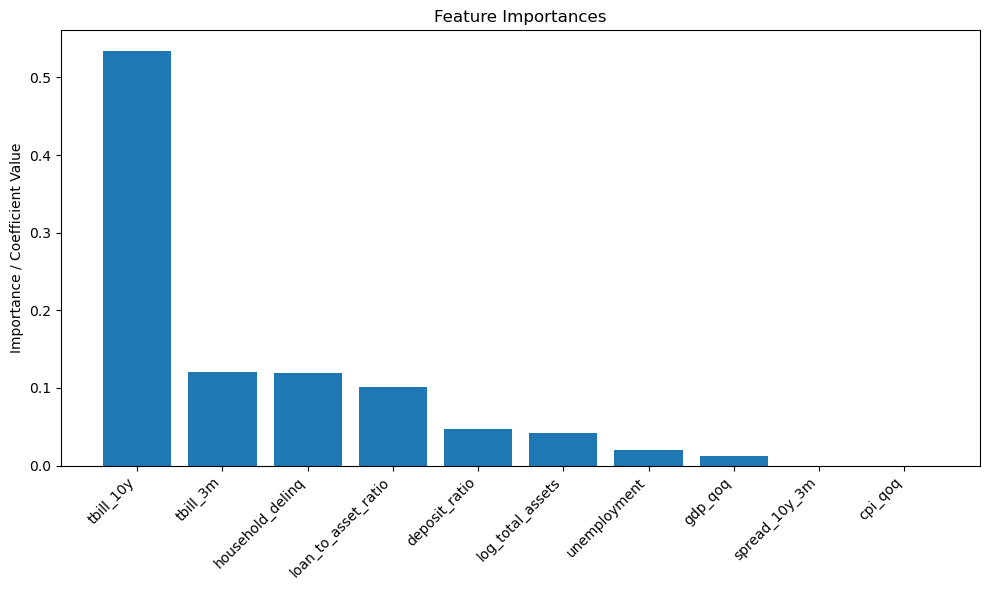

In [ ]:
# Function to plot feature importance for a given model
def plot_feature_importance(model, feature_names, ax=None):
    """Plots feature importance for tree-based models or coefficients for linear models."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    if hasattr(model, 'feature_importances_'):
        # For tree-based models like XGBoost, DecisionTreeRegressor
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]  # Sort by importance
        ax.bar(range(len(importances)), importances[indices], align='center')
        ax.set_xticks(range(len(importances)))
        ax.set_xticklabels(np.array(feature_names)[indices], rotation=45, ha='right')
        ax.set_title('Feature Importances')
    elif hasattr(model, 'coef_'):
        # For linear models like LinearRegression, Lasso, Ridge
        coef = model.coef_
        indices = np.argsort(np.abs(coef))[::-1]  # Sort by absolute value of coefficients
        ax.bar(range(len(coef)), coef[indices], align='center')
        ax.set_xticks(range(len(coef)))
        ax.set_xticklabels(np.array(feature_names)[indices], rotation=45, ha='right')
        ax.set_title('Feature Coefficients')

    ax.set_ylabel('Importance / Coefficient Value')
    plt.tight_layout()
    plt.show()

plot_feature_importance(
    results_store[1]['XGBoost']['model_object'], 
    FEATURE_VARIABLES, 
    ax=None  # Create a new figure and axis
)

In [ ]:
# Regression summary for linear regression models with confidence intervals
import statsmodels.api as sm
def regression_summary(model, X, y):
    """Generates a regression summary for linear models using statsmodels."""
    X_with_const = sm.add_constant(X)  # Add constant term for intercept
    model_sm = sm.OLS(y, X_with_const).fit()  # Fit the model
    print(model_sm.summary())  # Print the summary
regression_summary(
    results_store[1]['LinearRegression']['model_object'], 
    X_train_scaled_df, 
    y_train
)


                                     OLS Regression Results                                    
Dep. Variable:     interest_income_to_assets_target_h1   R-squared:                       0.569
Model:                                             OLS   Adj. R-squared:                  0.567
Method:                                  Least Squares   F-statistic:                     357.4
Date:                                 Sun, 01 Jun 2025   Prob (F-statistic):               0.00
Time:                                         13:47:37   Log-Likelihood:                 11149.
No. Observations:                                 2451   AIC:                        -2.228e+04
Df Residuals:                                     2441   BIC:                        -2.222e+04
Df Model:                                            9                                         
Covariance Type:                             nonrobust                                         
                          coef    std er